In [193]:
import os
from IPython.display import Image

import pandas as pd
import numpy as np
import itertools
import timeit
import time

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn import tree
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Display all columns
pd.set_option('display.max_columns', None)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from collections import Counter
from numpy import where
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean
from sklearn.decomposition import FastICA, PCA
from scipy.stats import kurtosis 
from sklearn import random_projection
from sklearn.decomposition import TruncatedSVD
from scipy.stats import kurtosis


In [2]:
df_patient = pd.read_csv("data/patientSurvivalPredication.csv")

assert df_patient.shape[0] > 0
assert df_patient.shape[1] > 0

print(f"Data has {df_patient.shape[0]} rows and {df_patient.shape[1]} columns.")

df_patient.drop(['encounter_id', 'patient_id', 'hospital_id', 'Unnamed: 83'], inplace=True, axis=1)

df_patient.fillna(-1, inplace=True)

# Replace -1 with empty string in string columns types
df_patient['ethnicity'].replace(-1, '', inplace=True)
df_patient['gender'].replace(-1, '', inplace=True)
df_patient['icu_stay_type'].replace(-1, "", inplace=True)
df_patient['icu_admit_source'].replace(-1, '', inplace=True)
df_patient['icu_type'].replace(-1, '', inplace=True)
df_patient['apache_3j_bodysystem'].replace(-1, '', inplace=True)
df_patient['apache_2_bodysystem'].replace(-1, '', inplace=True)

# Encode ethinicity as decision tree can't handle string values
enc = LabelEncoder()
enc.fit(df_patient['ethnicity'])

# Correct different spelling for same values
df_patient['apache_2_bodysystem'].replace("Undefined diagnoses", "Undefined Diagnoses", inplace=True)

# Create dummy columns for string columns so decision tree can proccess them
df_patient = pd.get_dummies(df_patient, columns=["ethnicity", "gender", "icu_stay_type", "icu_admit_source", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem"], prefix=["ethnicity_is", "gender_is", "icu_stay_type_is", "icu_admit_source_is", "icu_type_is", "apache_3j_bodysystem_is", "apache_2_bodysystem_is"] )

print(df_patient.shape)

Data has 91713 rows and 85 columns.
(91713, 123)


In [3]:
df_insurance = pd.read_csv('data/insurance/train.csv', nrows=100000)

assert df_insurance.shape[0] > 0
assert df_insurance.shape[1] > 0

print(f"Data has {df_insurance.shape[0]} rows and {df_insurance.shape[1]} columns.")

def encode_labels(df):
    for column in df.columns:
        if df[column].dtype=='object':
            label = LabelEncoder()
            label.fit(list(df[column].values))
            df[column] = label.transform(list(df[column].values))
    return df

df_insurance = df_insurance.drop(['QuoteNumber'], axis=1)

# Now convert the date to day, month and week and drop the date
df_insurance['Date'] = pd.to_datetime(pd.Series(df_insurance['Original_Quote_Date']))
df_insurance = df_insurance.drop('Original_Quote_Date', axis=1)
df_insurance['Year'] = df_insurance['Date'].apply(lambda x: int(str(x)[:4]))
df_insurance['Month'] = df_insurance['Date'].apply(lambda x: int(str(x)[5:7]))
df_insurance['weekday'] = df_insurance['Date'].dt.dayofweek
df_insurance = df_insurance.drop('Date', axis=1)
df_insurance = encode_labels(df_insurance)
df_insurance = df_insurance.fillna(-1)

insurance_X = df_insurance.loc[:, df_insurance.columns != 'QuoteConversion_Flag']
insurance_Y = df_insurance['QuoteConversion_Flag']

Data has 100000 rows and 299 columns.


In [124]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 


over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]

patient_Y = df_patient['hospital_death']
patient_X = df_patient.loc[:, df_patient.columns != 'hospital_death']
patient_X_resample, patient_Y_resample = Pipeline(steps=steps).fit_resample(patient_X, patient_Y)

patient_X_resample_scaled = StandardScaler().fit_transform(patient_X_resample) 

over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]

insurance_X = df_insurance.loc[:, df_insurance.columns != 'QuoteConversion_Flag']
insurance_Y = df_insurance['QuoteConversion_Flag']
insurance_X_resample, insurance_Y_resample = Pipeline(steps=steps).fit_resample(insurance_X, insurance_Y)

insurance_X_resample_scaled = StandardScaler().fit_transform(insurance_X_resample) 

patient_X_train, patient_X_test, patient_y_train, patient_y_test = train_test_split(np.array(patient_X_resample),np.array(patient_Y_resample), test_size=0.15)
insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(np.array(insurance_X_resample),np.array(insurance_Y_resample), test_size=0.15)


In [120]:
insurance_X_resample_scaled

array([[ 1.1034432 , -1.05145652,  0.777019  , ..., -1.02526722,
         0.09975901, -0.19336225],
       [ 0.63939434, -0.91761182,  1.39341535, ..., -1.02526722,
         0.09975901, -0.19336225],
       [ 1.1034432 ,  0.68852453, -1.30196696, ...,  0.36130399,
        -1.43127804,  1.47441857],
       ...,
       [ 0.63939434,  0.28699045,  1.35424248, ...,  0.36130399,
        -0.81886322, -0.74928919],
       [ 0.63939434, -1.45299061,  1.62861923, ...,  0.36130399,
         1.01838123, -0.19336225],
       [ 0.63939434, -1.45299061,  1.59311005, ...,  0.36130399,
        -1.43127804, -0.74928919]])

In [ ]:
##### pca = PCA().fit(patient_X_resample)

# # https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
# plt.title("Component-wise and Cumulative Explained Variance")
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title("PCA - Patient Dataset")
# plt.show()

pca = PCA().fit(patient_X_resample_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("PCA - Patient Dataset")
plt.show()

In [231]:
start = time.time()
pca = PCA(n_components=42).fit(patient_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", patient_X_resample_scaled.shape)
patient_X_resample_pca = pca.transform(patient_X_resample_scaled)
print("transformed shape:", patient_X_resample_pca.shape)
np.save('data/transformed/pca_patient.npy', patient_X_resample_pca)


Time(s) 0.2733500003814697
original shape: (25137, 122)
transformed shape: (25137, 42)


In [153]:
X_train, X_test, y_train, y_test = train_test_split(np.array(patient_X_resample_pca),np.array(patient_Y_resample), test_size=0.15)

clf = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')

scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
print('Mean CV ROC AUC: %.3f' % mean(scores))

clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
test_scores = roc_auc_score(y_test, y_pred_test)
print('Mean Test ROC AUC: %.3f' % mean(test_scores))


Mean CV ROC AUC: 0.741
Mean Test ROC AUC: 0.686


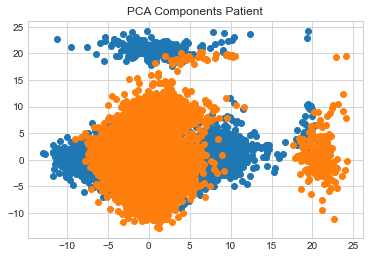

In [235]:
n = 2
pca = PCA(n_components=n) 
patient_X_resample_pca=pca.fit_transform(patient_X_resample_scaled)

plt.figure(figsize=(6,4))
plt.title('PCA Components Patient')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(patient_X_resample_pca[:,i], patient_X_resample_pca[:,j])


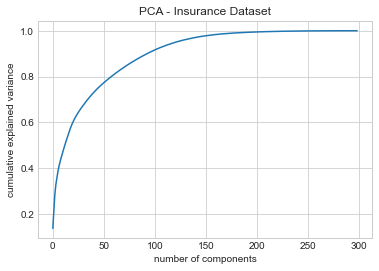

In [149]:
# pca = PCA().fit(insurance_X_resample)

# # https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
# plt.title("Component-wise and Cumulative Explained Variance")
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title("PCA - Insurance Dataset")
# plt.show()

pca = PCA().fit(insurance_X_resample_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("PCA - Insurance Dataset")
plt.show()

In [145]:
start = time.time()
pca = PCA(n_components=80).fit(insurance_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", insurance_X_resample_scaled.shape)
insurance_X_resample_pca = pca.transform(insurance_X_resample_scaled)
print("transformed shape:", insurance_X_resample_pca.shape)

np.save('data/transformed/pca_insurance.npy', insurance_X_resample_pca)

Time(s) 1.913285255432129
original shape: (73035, 299)
transformed shape: (73035, 80)


In [147]:
X_train, X_test, y_train, y_test = train_test_split(np.array(insurance_X_resample_pca),np.array(insurance_Y_resample), test_size=0.15)

clf = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')

scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
print('Mean CV ROC AUC: %.3f' % mean(scores))

clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
test_scores = roc_auc_score(y_test, y_pred_test)
print('Mean Test ROC AUC: %.3f' % mean(test_scores))

Mean CV ROC AUC: 0.759
Mean Test ROC AUC: 0.698


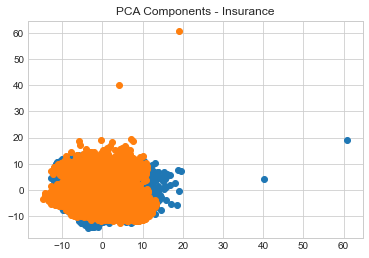

In [239]:
n = 2
pca = PCA(n_components=n) 
insurance_X_resample_pca=pca.fit_transform(insurance_X_resample_scaled)

plt.figure(figsize=(6,4))
plt.title('PCA Components - Insurance')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(insurance_X_resample_pca[:,i], insurance_X_resample_pca[:,j])

### ICA

In [198]:
best_n = (0, 0)
for i in range(2, 100):
    ica = FastICA(n_components=i, max_iter=10000, tol=0.2).fit(patient_X_resample_scaled)
    patient_X_resample_ica = ica.fit_transform(patient_X_resample_scaled)  
    k_score = np.average(abs(kurtosis(patient_X_resample_ica)))
    if (k_score > best_n[1]):
        best_n = (i, k_score)

clf = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 10)
print("Best n_components: " + str(best_n[0]))
ica = FastICA(n_components=int(best_n[0]), max_iter=10000, tol=0.2).fit(patient_X_resample_scaled)
patient_X_resample_ica = ica.fit_transform(patient_X_resample_scaled) 
patient_X_train, patient_X_test, patient_y_train, patient_y_test = train_test_split(patient_X_resample_ica, patient_Y_resample, test_size=0.2)
clf.fit(patient_X_train, patient_y_train)
patient_y_pred = clf.predict(patient_X_test)
score = roc_auc_score(patient_y_test, patient_y_pred)
print("ROC AUC Accuracy: " + str(score))
print("Test Accuracy: " + str(accuracy_score(patient_y_test, patient_y_pred)))



Best n_components: 59
ROC AUC Accuracy: 0.6860822091397788
Test Accuracy: 0.7271280827366746


In [200]:
n = 59
start = time.time()
ica = FastICA(n_components=n, max_iter=10000, tol=0.2) 
patient_X_resample_ica=ica.fit_transform(patient_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", patient_X_resample_scaled.shape)
print("transformed shape:", patient_X_resample_ica.shape)

np.save('data/transformed/ica_patient.npy', patient_X_resample_ica)

Time(s) 1.1455371379852295
original shape: (25137, 122)
transformed shape: (25137, 59)


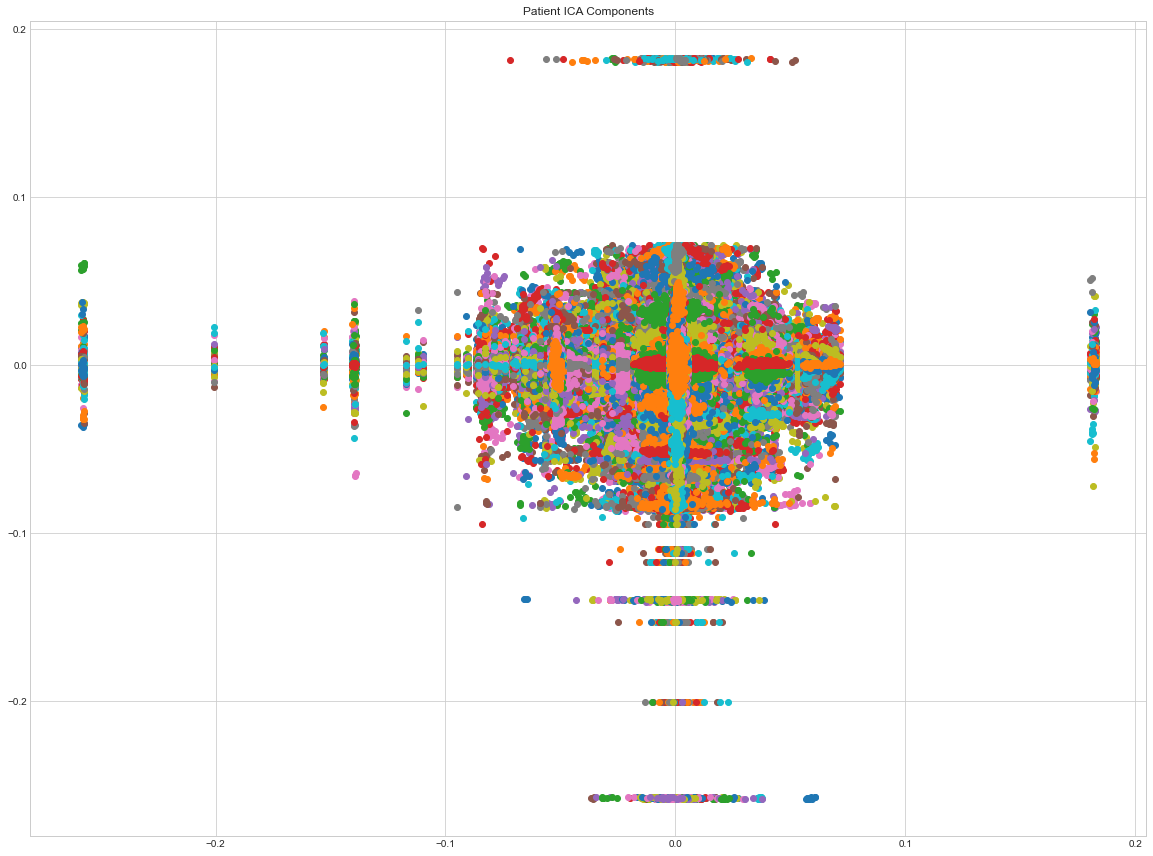

In [201]:
n = 59
ica = FastICA(n_components=n, max_iter=10000, tol=0.2) 
patient_X_resample_ica=ica.fit_transform(patient_X_resample_scaled)

plt.figure(figsize=(20,15))
plt.title('Patient ICA Components')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(patient_X_resample_ica[:,i], patient_X_resample_ica[:,j])


In [191]:
from scipy.stats import kurtosis

best_n = (0, 0)
for i in range(2, 80):
    ica = FastICA(n_components=i, max_iter=1000, tol=0.2).fit(insurance_X_resample_scaled)
    insurance_X_resample_ica = ica.fit_transform(insurance_X_resample_scaled)  
    k_score = np.average(abs(kurtosis(insurance_X_resample_ica)))
    if (k_score > best_n[1]):
        best_n = (i, k_score)
print(best_n)

(34, 1107.9824978174813)


In [192]:
clf = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 10)
ica = FastICA(n_components=34, max_iter=10000, tol=0.2).fit(insurance_X_resample_scaled)
insurance_X_resample_ica = ica.fit_transform(insurance_X_resample_scaled) 
insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(insurance_X_resample_ica, insurance_Y_resample, test_size=0.2)
clf.fit(insurance_X_train, insurance_y_train)
insurance_y_pred = clf.predict(insurance_X_test)
score = roc_auc_score(insurance_y_test, insurance_y_pred)
print("ROC AUC Accuracy: " + str(score))
print("Test Accuracy: " + str(accuracy_score(insurance_y_test, insurance_y_pred)))


ROC AUC Accuracy: 0.7265120974901056
Test Accuracy: 0.7623057438214554


In [195]:
n = 34
start = time.time()
ica = FastICA(n_components=n, max_iter=10000, tol=0.2) 
insurance_X_resample_ica=ica.fit_transform(insurance_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", insurance_X_resample_scaled.shape)
print("transformed shape:", insurance_X_resample_ica.shape)
np.save('data/transformed/ica_insurance.npy', insurance_X_resample_ica)

Time(s) 5.050757884979248
original shape: (73035, 299)
transformed shape: (73035, 34)


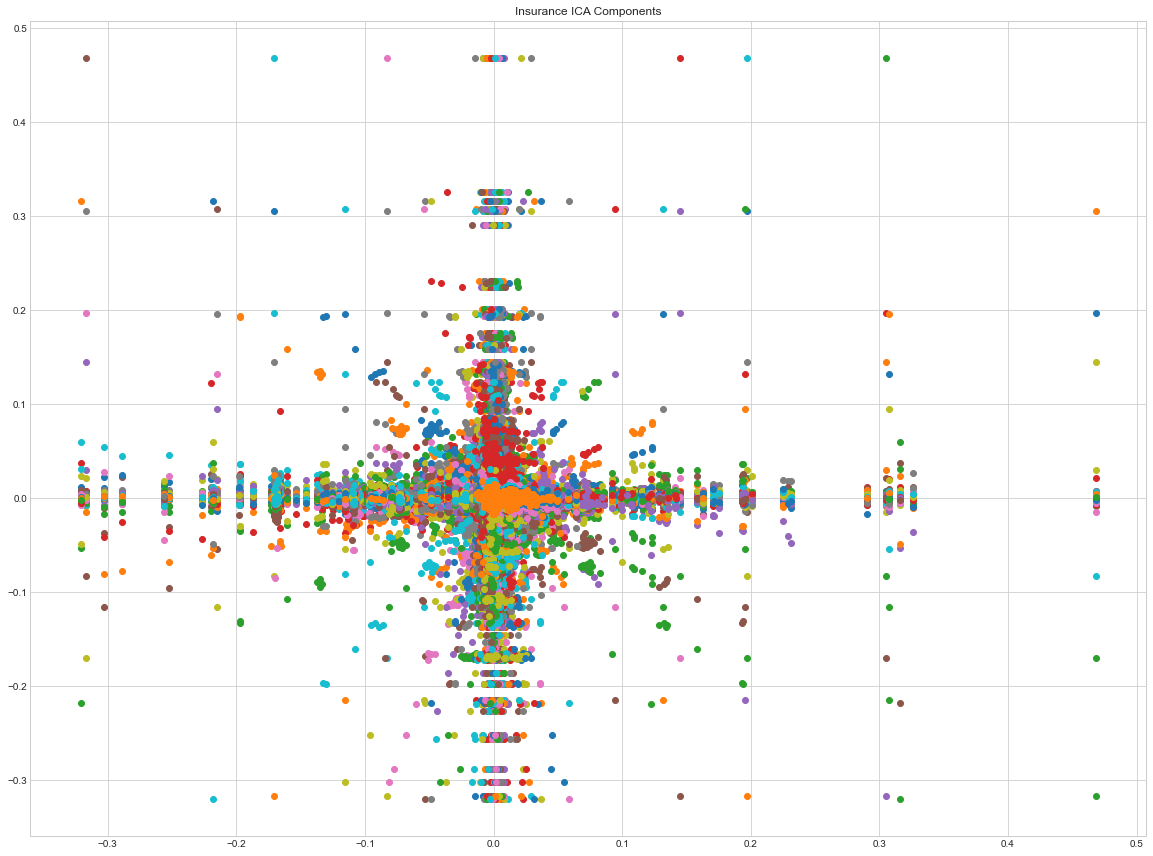

In [196]:
n = 34
ica = FastICA(n_components=n, max_iter=10000, tol=0.2) 
insurance_X_resample_ica=ica.fit_transform(insurance_X_resample_scaled)

plt.figure(figsize=(20,15))
plt.title('Insurance ICA Components')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(insurance_X_resample_ica[:,i], insurance_X_resample_ica[:,j])


### Randomized Projections

In [172]:
best_n = (0, 0)
for i in range(2, 50):
    rp = random_projection.SparseRandomProjection(n_components=i, random_state=20).fit(patient_X_resample_scaled)
    patient_X_resample_rp = rp.fit_transform(patient_X_resample_scaled)  
    X_train, X_test, y_train, y_test = train_test_split(patient_X_resample_rp, patient_Y_resample, test_size=0.2)
    clf = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 10)
    cv_score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5).mean()
    if (cv_score > best_n[1]):
        best_n = (i, cv_score)

print("Best n_components: " + str(best_n[0]))

clf = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 10)
rp = random_projection.SparseRandomProjection(n_components=best_n[0], random_state=20).fit(patient_X_resample_scaled)
patient_X_resample_rp = rp.fit_transform(patient_X_resample_scaled)  
patient_X_train, patient_X_test, patient_y_train, patient_y_test = train_test_split(patient_X_resample_rp, patient_Y_resample, test_size=0.2)
clf.fit(patient_X_train, patient_y_train)
patient_y_pred = clf.predict(patient_X_test)
score = roc_auc_score(patient_y_test, patient_y_pred)
print("ROC AUC Accuracy: " + str(score))
print("Test Accuracy: " + str(accuracy_score(patient_y_test, patient_y_pred)))


Best n_components: 38
ROC AUC Accuracy: 0.6803158431731775
Test Accuracy: 0.7281225139220366


In [226]:
n = 38
start = time.time()
rp = random_projection.SparseRandomProjection(n_components=n, random_state=20).fit(patient_X_resample_scaled)
patient_X_resample_rp = rp.fit_transform(patient_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", patient_X_resample_scaled.shape)
print("transformed shape:", patient_X_resample_rp.shape)

np.save('data/transformed/rp_patient.npy', patient_X_resample_rp)

Time(s) 0.025789976119995117
original shape: (25137, 122)
transformed shape: (25137, 38)


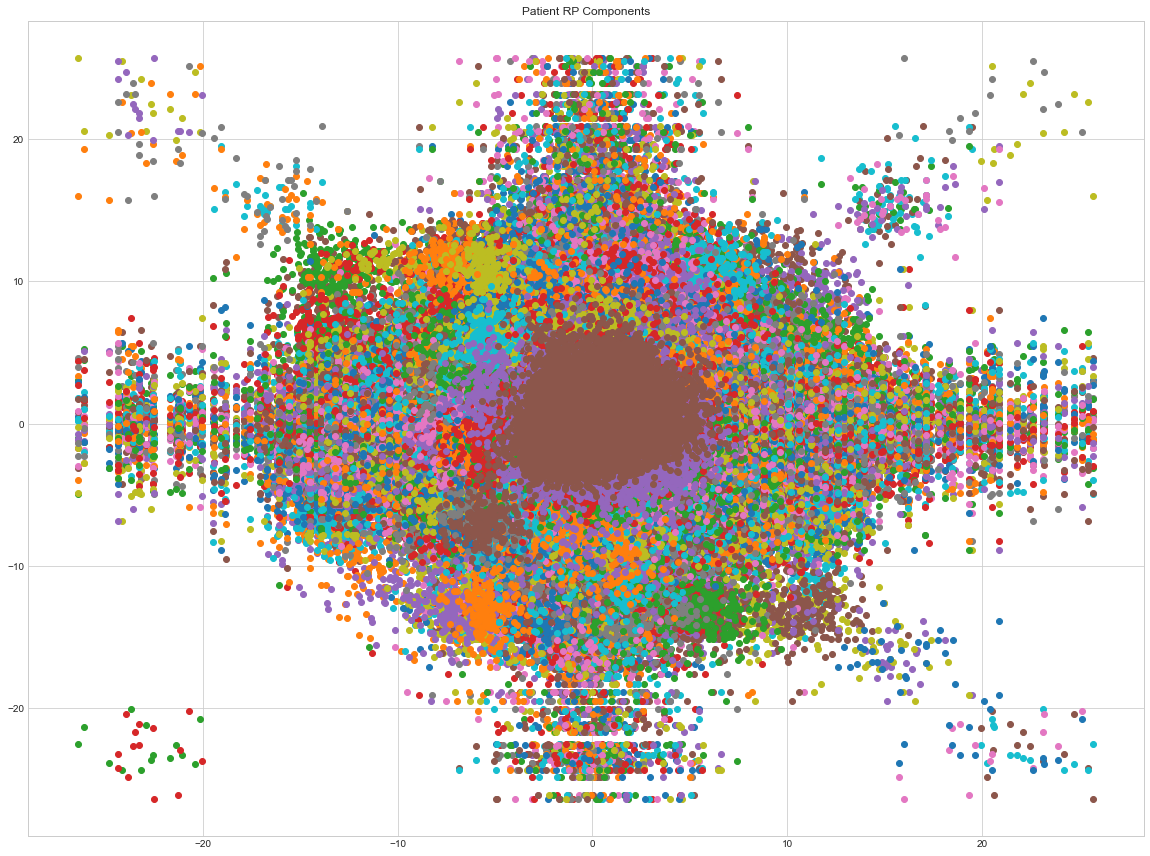

In [219]:
n = 38
rp = random_projection.SparseRandomProjection(n_components=n)
patient_X_resample_rp=rp.fit_transform(patient_X_resample_scaled)

plt.figure(figsize=(20,15))
plt.title('Patient RP Components')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(patient_X_resample_rp[:,i], patient_X_resample_rp[:,j])


In [225]:
best_n = (0, 0)
for i in range(2, 31):
    rp = random_projection.SparseRandomProjection(n_components=i, random_state=20).fit(insurance_X_resample_scaled)
    insurance_X_resample_rp = rp.fit_transform(insurance_X_resample_scaled)  
    X_train, X_test, y_train, y_test = train_test_split(insurance_X_resample_rp, insurance_Y_resample, test_size=0.2)
    clf = DecisionTreeClassifier(max_depth = 35, min_samples_leaf = 10)
    cv_score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5).mean()
    if (cv_score > best_n[1]):
        best_n = (i, cv_score)

print("Best n_components: " + str(best_n[0]))

clf = DecisionTreeClassifier(max_depth = 35, min_samples_leaf = 10)
rp = random_projection.SparseRandomProjection(n_components=best_n[0], random_state=20).fit(insurance_X_resample_scaled)
insurance_X_resample_rp = rp.fit_transform(insurance_X_resample_scaled)  
insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(insurance_X_resample_rp, insurance_Y_resample, test_size=0.2)
clf.fit(insurance_X_train, insurance_y_train)
insurance_y_pred = clf.predict(insurance_X_test)
score = roc_auc_score(insurance_y_test, insurance_y_pred)
print("ROC AUC Accuracy: " + str(score))
print("Test Accuracy: " + str(accuracy_score(insurance_y_test, insurance_y_pred)))

Best n_components: 24
ROC AUC Accuracy: 0.6579447304823837
Test Accuracy: 0.7067159581022797


In [227]:
n = 24
start = time.time()
rp = random_projection.SparseRandomProjection(n_components=n, random_state=20).fit(insurance_X_resample_scaled)
insurance_X_resample_rp = rp.fit_transform(insurance_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", insurance_X_resample_scaled.shape)
print("transformed shape:", insurance_X_resample_rp.shape)

np.save('data/transformed/rp_insurance.npy', insurance_X_resample_rp)

Time(s) 0.07135319709777832
original shape: (73035, 299)
transformed shape: (73035, 24)


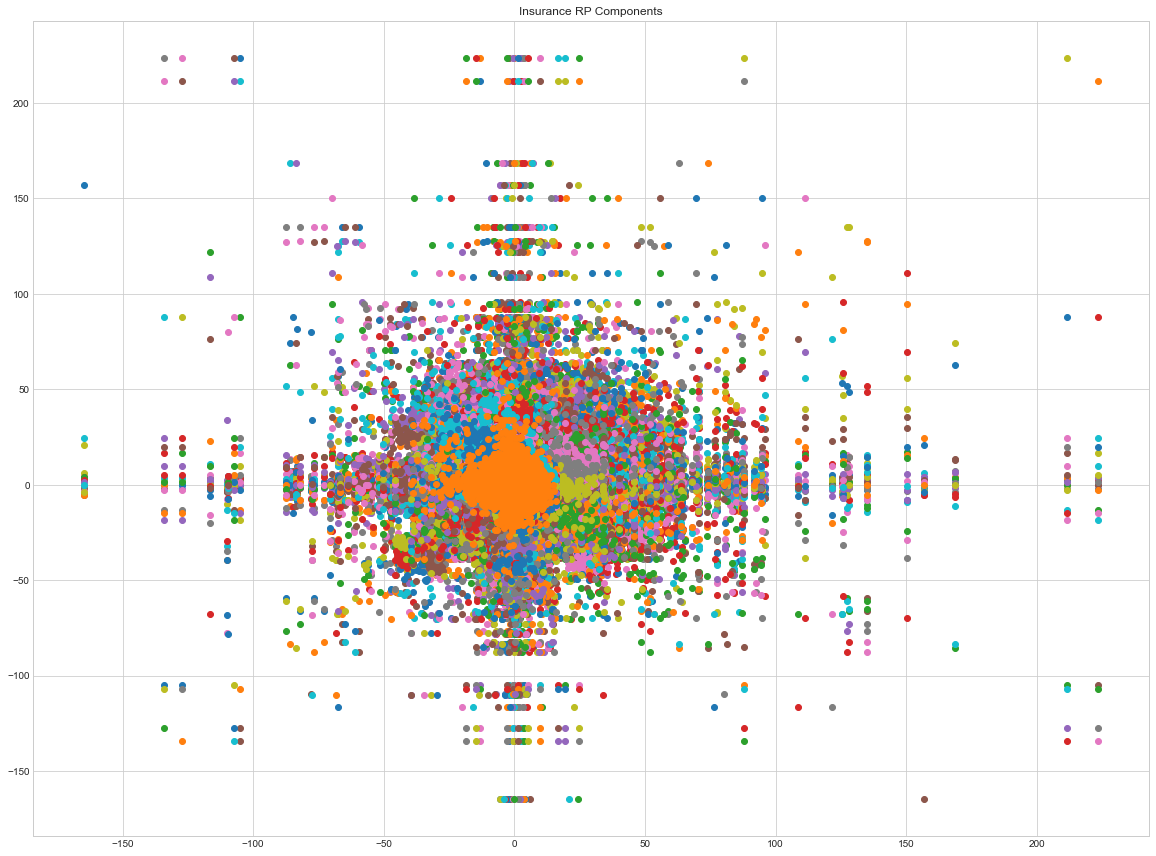

In [228]:
n = 24
rp = random_projection.SparseRandomProjection(n_components=n)
insurance_X_resample_rp=rp.fit_transform(insurance_X_resample_scaled)

plt.figure(figsize=(20, 15))
plt.title('Insurance RP Components')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(insurance_X_resample_rp[:,i], insurance_X_resample_rp[:,j])


57

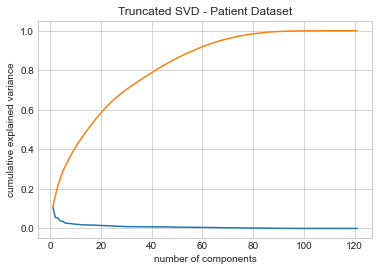

In [207]:
tsvd = TruncatedSVD(n_components=patient_X_resample_scaled.shape[1]-1)
patient_tsvd = tsvd.fit(patient_X_resample_scaled)

tsvd_var_ratios = tsvd.explained_variance_ratio_
plt.plot(range(1, len(tsvd_var_ratios) + 1), tsvd_var_ratios)
plt.plot(range(1, len(tsvd_var_ratios) + 1), np.cumsum(tsvd_var_ratios))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Truncated SVD - Patient Dataset")

# https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/

def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

select_n_components(tsvd_var_ratios, 0.90)


In [210]:
svd = TruncatedSVD(n_components=57).fit(patient_X_resample_scaled)
patient_svd = svd.fit_transform(patient_X_resample_scaled)
patient_X_train, patient_X_test, patient_y_train, patient_y_test = train_test_split(patient_svd, patient_Y_resample, test_size=0.2)
clf.fit(patient_X_train, patient_y_train)
patient_y_pred = clf.predict(patient_X_test)
score = accuracy_score(patient_y_test, patient_y_pred)
roc_score = roc_auc_score(patient_y_test, patient_y_pred)
print("Test Accuracy: " + str(score))
print("Test RUC AOC: " + str(roc_score))


Test Accuracy: 0.7295147175815434
Test RUC AOC: 0.686240196173971


In [212]:
n = 57
start = time.time()
svd = TruncatedSVD(n_components=57).fit(patient_X_resample_scaled)
patient_svd = svd.fit_transform(patient_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", patient_X_resample_scaled.shape)
print("transformed shape:", patient_svd.shape)
np.save('data/transformed/tsvd_patient.npy', patient_svd)

Time(s) 0.7079958915710449
original shape: (25137, 122)
transformed shape: (25137, 57)


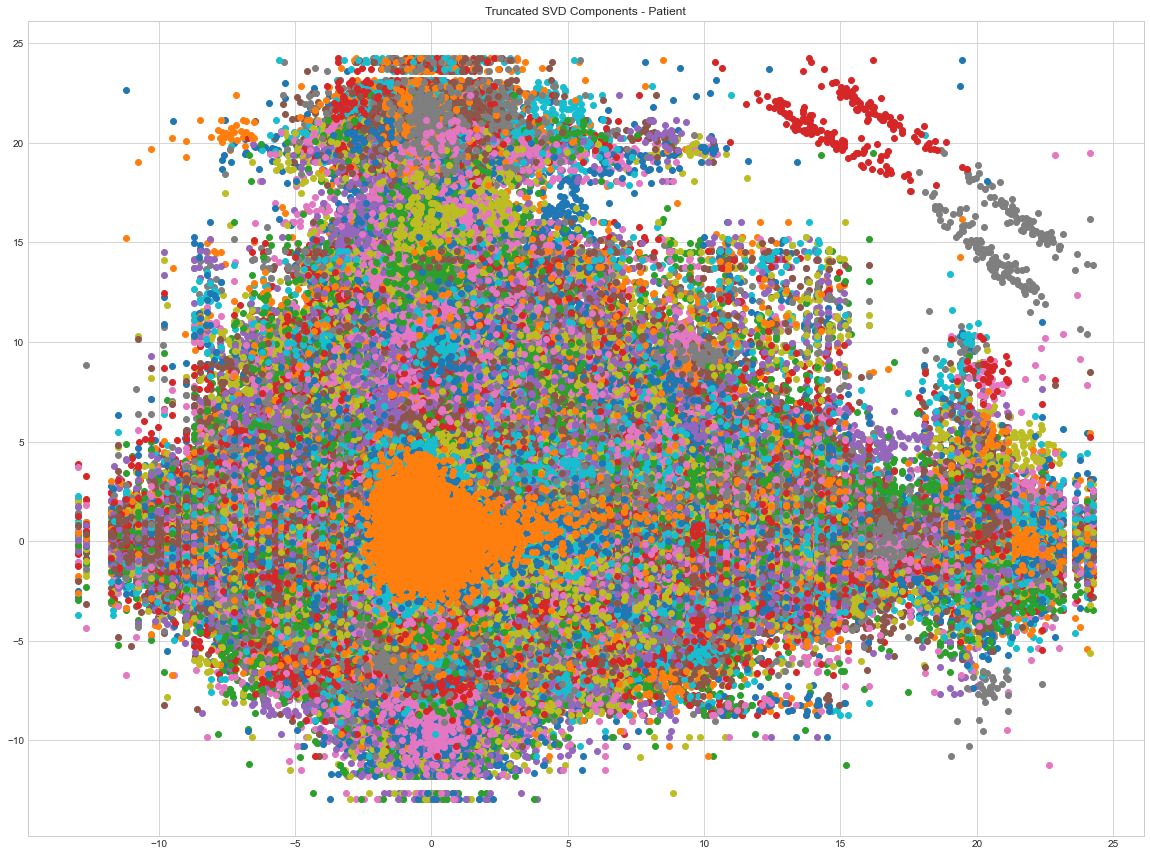

In [214]:
n = 57
svd = TruncatedSVD(n_components=57).fit(patient_X_resample_scaled)
patient_svd = svd.fit_transform(patient_X_resample_scaled)

plt.figure(figsize=(20,15))
plt.title('Truncated SVD Components - Patient')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(patient_svd[:,i], patient_svd[:,j])

94

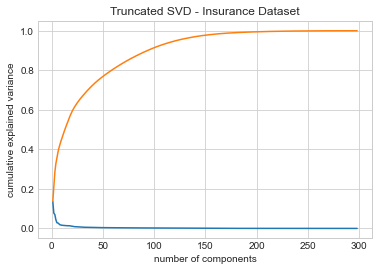

In [206]:
tsvd = TruncatedSVD(n_components=insurance_X_resample_scaled.shape[1]-1)
insurance_tsvd = tsvd.fit(insurance_X_resample_scaled)

tsvd_var_ratios = tsvd.explained_variance_ratio_
plt.plot(range(1, len(tsvd_var_ratios) + 1), tsvd_var_ratios)
plt.plot(range(1, len(tsvd_var_ratios) + 1), np.cumsum(tsvd_var_ratios))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Truncated SVD - Insurance Dataset")

# https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/

def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

select_n_components(tsvd_var_ratios, 0.90)


In [215]:
svd = TruncatedSVD(n_components=94).fit(insurance_X_resample_scaled)
insurance_svd = svd.fit_transform(insurance_X_resample_scaled)
insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(insurance_svd, insurance_Y_resample, test_size=0.2)
clf.fit(insurance_X_train, insurance_y_train)
insurance_y_pred = clf.predict(insurance_X_test)
score = accuracy_score(insurance_y_test, insurance_y_pred)
roc_score = roc_auc_score(insurance_y_test, insurance_y_pred)
print("Test Accuracy: " + str(score))
print("Test RUC AOC: " + str(roc_score))

Test Accuracy: 0.7324570411446567
Test RUC AOC: 0.6941828370569938


In [216]:
n = 94
start = time.time()
svd = TruncatedSVD(n_components=n).fit(insurance_X_resample_scaled)
insurance_svd = svd.fit_transform(insurance_X_resample_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", insurance_X_resample_scaled.shape)
print("transformed shape:", insurance_svd.shape)
np.save('data/transformed/tsvd_insurance.npy', insurance_svd)

Time(s) 4.7623209953308105
original shape: (73035, 299)
transformed shape: (73035, 94)


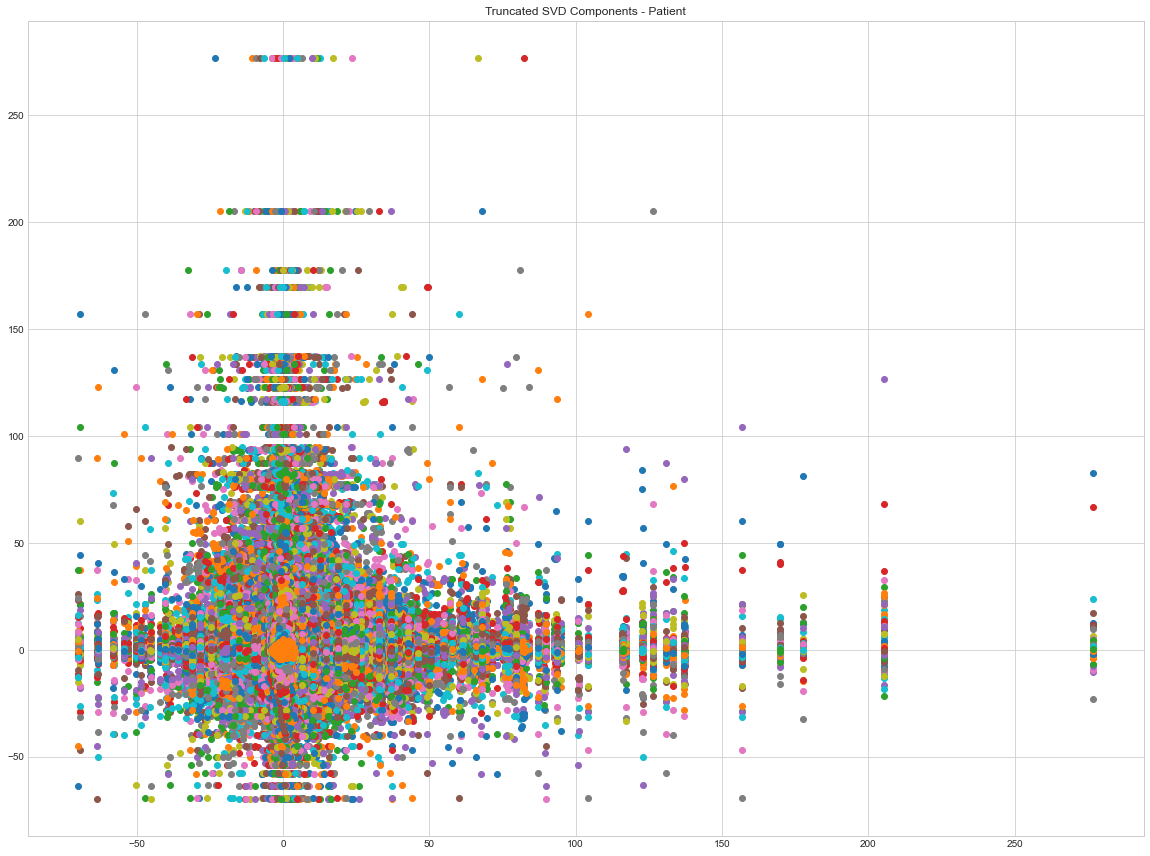

In [217]:
plt.figure(figsize=(6,4))
plt.title('Truncated SVD Components - Patient')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(insurance_svd[:,i], insurance_svd[:,j])